In [1]:

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession


In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [3]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-11-06 03:17:21--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-11-06 03:17:21--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-11-06 03:17:22--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [4]:
df = spark.read.parquet('washing.parquet')

In [5]:
df.count() #rows

2058

In [6]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

So let's visualize voltage using a box plot to get an idea on the value distribution of this parameter. First, we have to create a python list. Make sure you use the sample function in order to not blast your spark driver or plotting library.

In [7]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[225, 226, 232, 239, 229, 229, 225, 229, 238, 234, 224, 239, 221, 230, 238]

Now it's time to plot the python list by importing the matplotlib library, calling "boxplot" and "show". Note that you can see mean (red line) around 230. Then you see that 50% of all values are between 225 and 235 (blue box). Per default values up to 250 are not seen as outliers (little, black horizontal line). And the "plus" symbols on top are definitely outliers. Congratulations, you've written your first anomaly detection algorithm. Unfurtunately you still need a brain attached to it, so we'll cover on how we write one without a brain needed in the next course. And in the course after that we'll even tell you how to implement a artificial brain to further improve it, so stay tuned :)

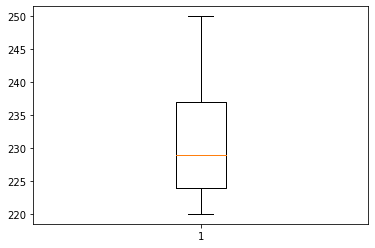

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

Since we are dealing with time series data we want to make use of the time dimension as well. The least complex plots are run charts where the time domain (dimension) is represented at the horizontal x-axis and the y-axis shows the actual sensor value. Let's do this for voltage as well.

In [9]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808740927, 1547808803962, 1547808806965, 1547808818973, 1547808846029, 1547808858035, 1547808864037, 1547808870039, 1547808894081, 1547808903087, 1547808972147, 1547808987166, 1547809062222, 1547809065223, 1547809083238]
[235, 237, 221, 237, 233, 228, 235, 231, 225, 220, 222, 237, 238, 222, 224]


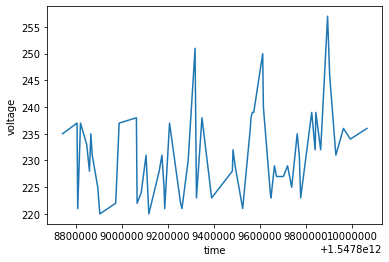

In [10]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

But this time we want to only plot data worth of one hour. Therefore we first have to find out in which date range we have data available:



In [11]:
spark.sql("select min(ts),max(ts) from washing").show()


+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



Now lets repeat the previous steps but only show data for hour. We've found out the low and high boundary of data available and we know that "ts" stand for "timestamp". Timestamp are the number of millisecons passed since the 1st of Jan. 1970. You can also use an online tool like http://www.epochconverter.com/ to convert these. But for now just an interval of 60 minutes (10006060)=3600000 within the range above (note that we have removed the sample function because the data set is already reduced)

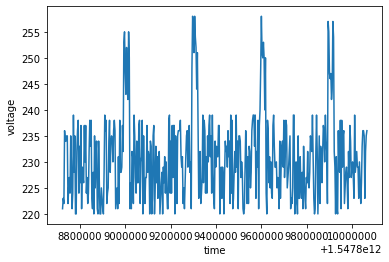

In [12]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

As you can see we are not only able to spot the outliers but also see a time pattern of these outliers occuring which can be used for further downstream analysis. Again your brain was already capable of spotting the pattern. In the next two coursera courses we will teach a machine to spot those patterns as well.

Now we've plotted a maximum of two dimensions at a time, let's go for three in a so-called 3D scatter plot. Again we have to create python lists (with applied sampling if necessary) from three properties of our data.

In [13]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

Once done it is very simple to import the necessary library and create a scatter plot

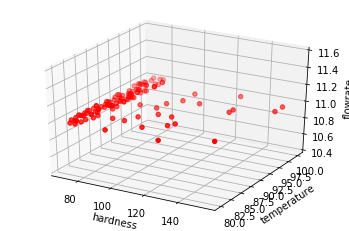

In [14]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

You will notice that the individual points resemble in some sort of plane. But this is not a surprise. Actually we can draw the following conclusions from the plot:

most of the data points are lying around hardness 60-80, temperature 80-100 and flowrate 80-100
there are some outliers, especially when it comes to the range of hardness 100-200
the data follows some narrow boundaries
So lets double-check what's going on with hardness since it seems that it really sticks around 60-80 and very seldom creates values above that. We can use a histogram for that which bins together certain value ranges and counts the frequency of occurences of values within this range. Those frequencies are ordered and shown as a bar diagram, so let's plot it:

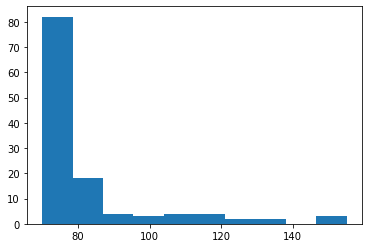

In [15]:
plt.hist(result_array_hardness)
plt.show()

Our assumpion was correct, nearly all values are around 60-80 with very less values about that threshold.

In [16]:
df= spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [17]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

Since this table contains null values also our window might contain them. In case for a certain feature all values in that window are null we obtain also null. As we can see here (in my dataset) this is the case for 9 rows.

In [18]:
df.count()-result.count()

7

Now we import some classes from SparkML. PCA for the actual algorithm. Vectors for the data structure expected by PCA and VectorAssembler to transform data into these vector structures.

In [19]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Let's define a vector transformation helper class which takes all our input features (result.columns) and created one additional column called "features" which contains all our input features as one single column wrapped in "DenseVector" objects

In [20]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

Now we actually transform the data, note that this is highly optimized code and runs really fast in contrast if we had implemented it.

In [21]:
features = assembler.transform(result)

Let's have a look at how this new additional column "features" looks like:


In [22]:
features.rdd.map(lambda r : r.features).take(10)


[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

Since the source data set has been prepared as a list of DenseVectors we can now apply PCA. Note that the first line again only prepares the algorithm by finding the transformation matrices (fit method)


In [23]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

Now we can actually transform the data. Let's have a look at the first 20 rows


In [24]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

So we obtained three completely new columns which we can plot now. Let run a final check if the number of rows is the same.



In [25]:
result_pca.count()

2051

Cool, this works as expected. Now we obtain a sample and read each of the three columns into a python list



In [26]:
rdd = result_pca.rdd.sample(False,0.8)


In [27]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()


In [28]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()


In [29]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()


Finally we plot the three lists and name each of them as dimension 1-3 in the plot



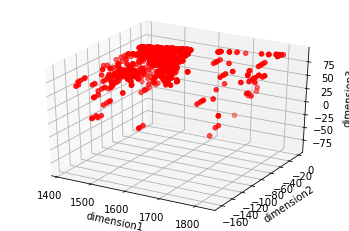

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

We can see two clusters in the data set. We can also see a third cluster which either can be outliers or a real cluster. In the next course we will actually learn how to compute clusters automatically. For now we know that the data indicates that there are two semi-stable states of the machine and sometime we see some anomalies since those data points don't fit into one of the two clusters.